Basic imports beforehand

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's grab our cleaned data and put it in a pandas DataFrame. Let's remove the games that were terminated early because one of the players was cheating, as these games aren't fair and shouldn't be considered in our analysis.

In [2]:
url="https://github.com/silas-wunder/Data-Wrangling-Final-Project/blob/main/Chess_Data.pickle?raw=true"
data = pd.read_pickle(url).astype({'Game Type': 'category', 'Result': 'category', 'White ELO': 'uint16',\
     'Black ELO': 'uint16', 'Termination': 'category', 'Moves': 'uint8'})
# drop any game that terminated with 'rules infraction'
data.drop(data.loc[data['Termination'] == 'Rules infraction'].index, inplace=True)
data.head()

,Game Type,Result,White ELO,Black ELO,Termination,Moves
0,Bullet,0-1,1489,1797,Time forfeit,40
1,Blitz,0-1,1379,1558,Normal,30
2,Blitz,1-0,1666,1258,Normal,20
3,Bullet,0-1,1528,1662,Time forfeit,46
4,Bullet,1-0,1528,1504,Time forfeit,22


Let's begin by visualizing how many games are won by white, how many games are won by black, and how many games are draws.

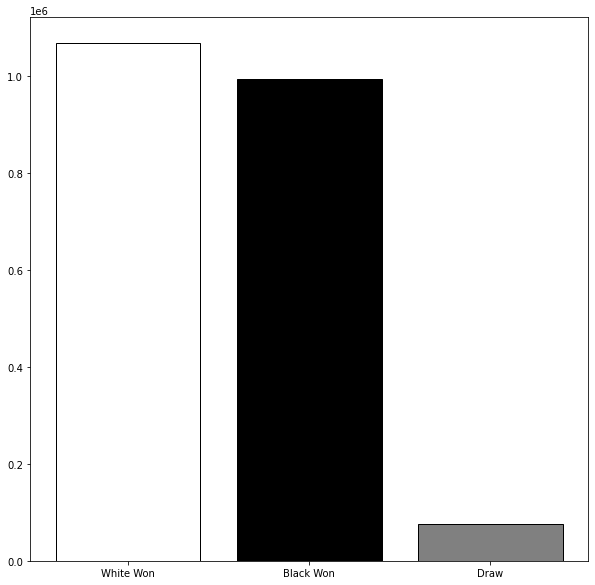

In [3]:
fig, ax = plt.subplots(figsize=(10,10))
ax.bar('White Won', len(data.loc[data['Result'] == '1-0']), color='white', edgecolor='black')
ax.bar('Black Won', len(data.loc[data['Result'] == '0-1']), color='black', edgecolor='black')
ax.bar('Draw', len(data.loc[data['Result'] == '1/2-1/2']), color='gray', edgecolor='black');

Overall, it looks like White wins more often than black. Let's break it down by `Game Type` to see if the format of the game has an effect on who wins.

Note: we could also break it down using `Time Control`, though `Game Type` encapsulates this information by categorizing the time control as a game type by estimating total game time. More information about this can be found on [Lichess' Website](https://lichess.org/faq#time-controls).

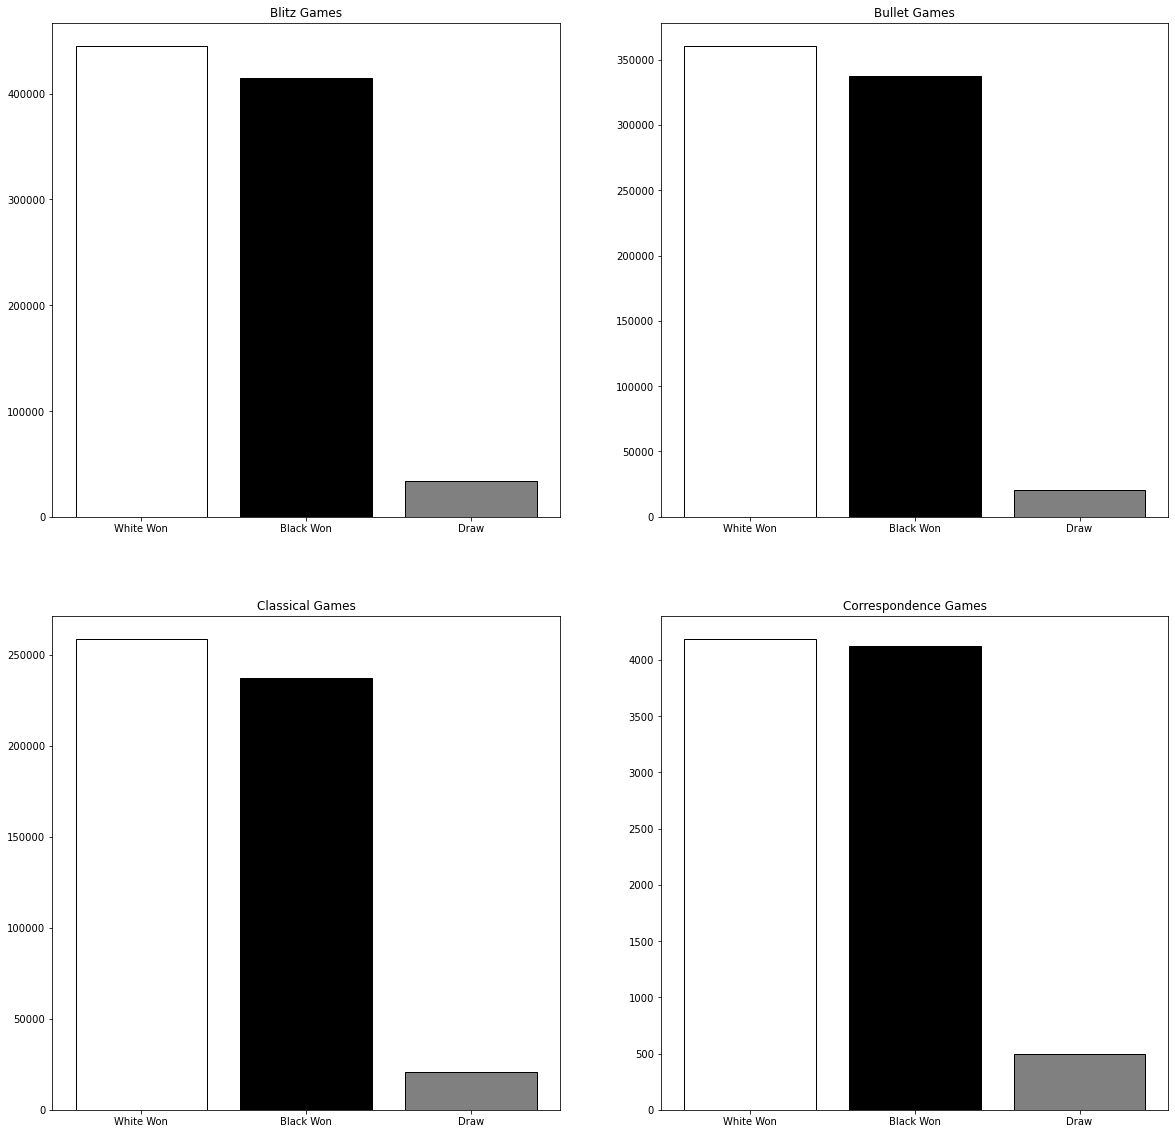

In [4]:
labels = np.unique(data['Game Type'])
whiteWon0 = len(data.loc[(data['Game Type'] == labels[0]) & (data['Result'] == '1-0')])
blackWon0 = len(data.loc[(data['Game Type'] == labels[0]) & (data['Result'] == '0-1')])
draw0 = len(data.loc[(data['Game Type'] == labels[0]) & (data['Result'] == '1/2-1/2')])
whiteWon1 = len(data.loc[(data['Game Type'] == labels[1]) & (data['Result'] == '1-0')])
blackWon1 = len(data.loc[(data['Game Type'] == labels[1]) & (data['Result'] == '0-1')])
draw1 = len(data.loc[(data['Game Type'] == labels[1]) & (data['Result'] == '1/2-1/2')])
whiteWon2 = len(data.loc[(data['Game Type'] == labels[2]) & (data['Result'] == '1-0')])
blackWon2 = len(data.loc[(data['Game Type'] == labels[2]) & (data['Result'] == '0-1')])
draw2 = len(data.loc[(data['Game Type'] == labels[2]) & (data['Result'] == '1/2-1/2')])
whiteWon3 = len(data.loc[(data['Game Type'] == labels[3]) & (data['Result'] == '1-0')])
blackWon3 = len(data.loc[(data['Game Type'] == labels[3]) & (data['Result'] == '0-1')])
draw3 = len(data.loc[(data['Game Type'] == labels[3]) & (data['Result'] == '1/2-1/2')])

fig, axs = plt.subplots(2, 2, figsize=(20,20))
axs[0,0].bar('White Won', whiteWon0, color='white', edgecolor='black')
axs[0,0].bar('Black Won', blackWon0, color='black', edgecolor='black')
axs[0,0].bar('Draw', draw0, color='gray', edgecolor='black')
axs[0,0].set_title('Blitz Games')
axs[0,1].bar('White Won', whiteWon1, color='white', edgecolor='black')
axs[0,1].bar('Black Won', blackWon1, color='black', edgecolor='black')
axs[0,1].bar('Draw', draw1, color='gray', edgecolor='black')
axs[0,1].set_title('Bullet Games')
axs[1,0].bar('White Won', whiteWon2, color='white', edgecolor='black')
axs[1,0].bar('Black Won', blackWon2, color='black', edgecolor='black')
axs[1,0].bar('Draw', draw2, color='gray', edgecolor='black')
axs[1,0].set_title('Classical Games')
axs[1,1].bar('White Won', whiteWon3, color='white', edgecolor='black')
axs[1,1].bar('Black Won', blackWon3, color='black', edgecolor='black')
axs[1,1].bar('Draw', draw3, color='gray', edgecolor='black')
axs[1,1].set_title('Correspondence Games');

It doesn't look like the trend changes that much when we break the data down by `Game Type`, other than longer games having a higher draw rate, most likely due to players having more time to think and make smarter moves. Maybe the ELO of the players gives a better idea of who will win?

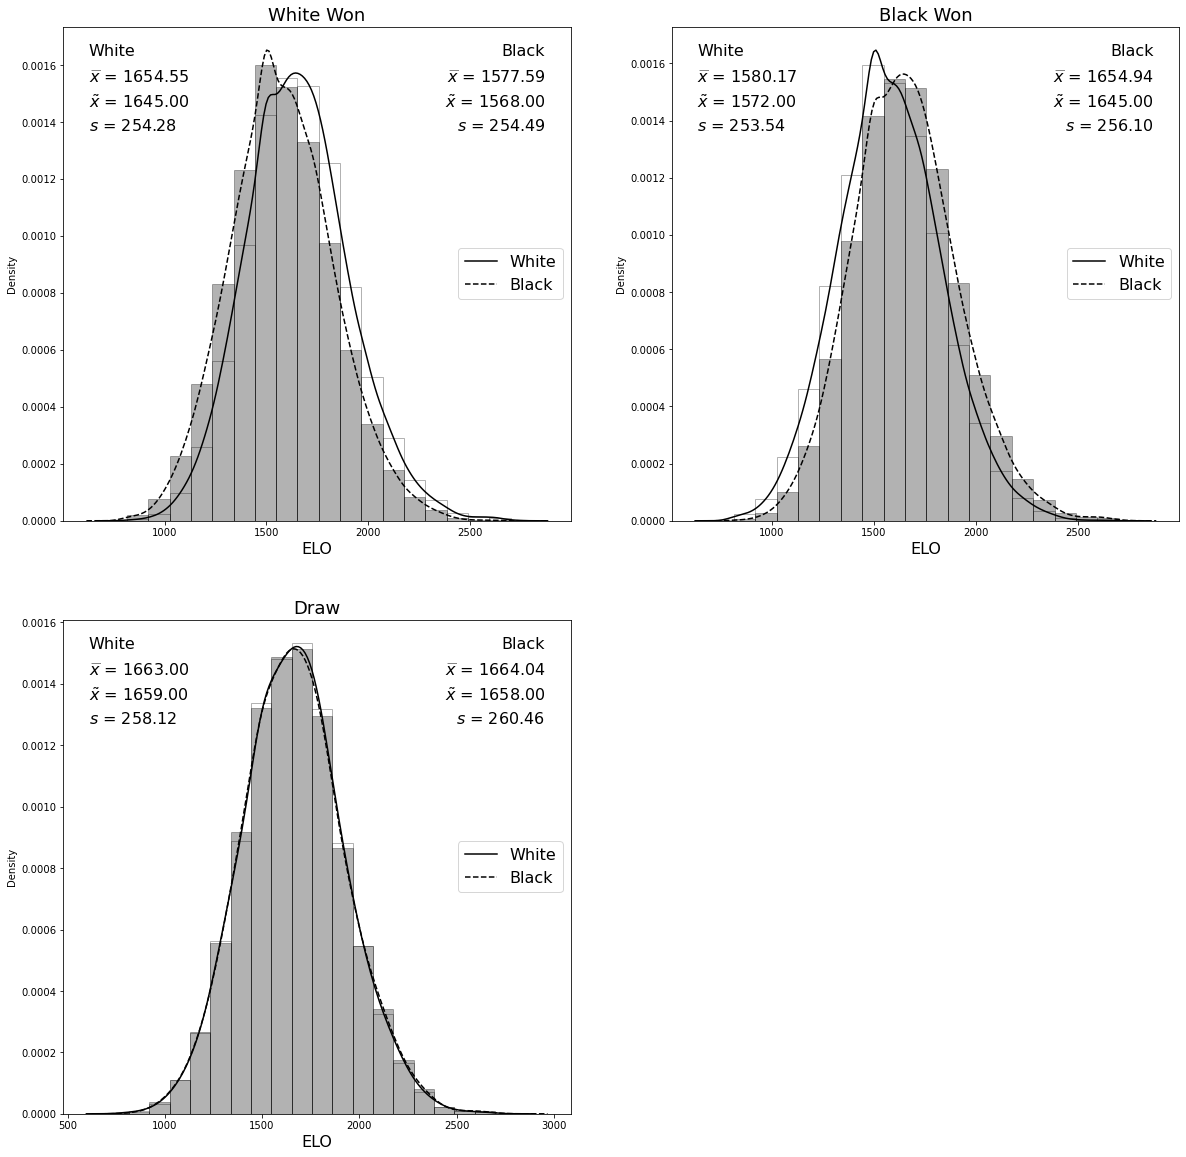

In [5]:
# in the cleaning code, any ELO of '?' was set to 0, we should remove these values because they aren't actually 0s
data.drop(data.loc[(data['White ELO'] == 0) | (data['Black ELO'] == 0)].index, inplace=True)
whiteWonELOs = data.loc[data['Result'] == '1-0', ['Black ELO', 'White ELO']]
blackWonELOs = data.loc[data['Result'] == '0-1', ['Black ELO', 'White ELO']]
drawELOs = data.loc[data['Result'] == '1/2-1/2', ['Black ELO', 'White ELO']]
# set the range so every histogram looks the same
r = (min(np.min(data['White ELO']), np.min(data['Black ELO'])), max(np.max(data['White ELO']), np.max(data['Black ELO'])))

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
fig.delaxes(axs[1,1])

# draw histograms of every ELO and overlay kernel density estimation lines
axs[0,0].hist(whiteWonELOs['White ELO'], bins=20, range=r, density=True, color='white', edgecolor='black', alpha=0.3)
sns.kdeplot(data=whiteWonELOs, x='White ELO', bw_adjust=2, ax=axs[0,0], label='White', color='black')
axs[0,0].hist(whiteWonELOs['Black ELO'], bins=20, range=r, density=True, color='black', edgecolor='black', alpha=0.3)
sns.kdeplot(data=whiteWonELOs, x='Black ELO', bw_adjust=2, ax=axs[0,0], label='Black', color='black', linestyle='dashed')
axs[0,1].hist(blackWonELOs['White ELO'], bins=20, range=r, density=True, color='white', edgecolor='black', alpha=0.3)
sns.kdeplot(data=blackWonELOs, x='White ELO', bw_adjust=2, ax=axs[0,1], label='White', color='black')
axs[0,1].hist(blackWonELOs['Black ELO'], bins=20, range=r, density=True, color='black', edgecolor='black', alpha=0.3)
sns.kdeplot(data=blackWonELOs, x='Black ELO', bw_adjust=2, ax=axs[0,1], label='Black', color='black', linestyle='dashed')
axs[1,0].hist(drawELOs['White ELO'], bins=20, range=r, density=True, color='white', edgecolor='black', alpha=0.3)
sns.kdeplot(data=drawELOs, x='White ELO', bw_adjust=2, ax=axs[1,0], label='White', color='black')
axs[1,0].hist(drawELOs['Black ELO'], bins=20, range=r, density=True, color='black', edgecolor='black', alpha=0.3)
sns.kdeplot(data=drawELOs, x='Black ELO', bw_adjust=2, ax=axs[1,0], label='Black', color='black', linestyle='dashed')

# add titles and labels to make graphs more informative
axs[0,0].set_title('White Won', fontsize=18)
axs[0,0].set_xlabel('ELO', fontsize=16)
axs[0,0].text(0.05, 0.95, 'White', transform=axs[0,0].transAxes, horizontalalignment='left',\
     verticalalignment='center', fontsize=16)
axs[0,0].text(0.05, 0.9, f"$\widebar{{x}}$ = {np.mean(whiteWonELOs['White ELO']):.2f}",\
     transform=axs[0,0].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=16)
axs[0,0].text(0.05, 0.85, fr"$\tilde{{x}}$ = {np.median(whiteWonELOs['White ELO']):.2f}",\
     transform=axs[0,0].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=16)
axs[0,0].text(0.05, 0.8, f"$s$ = {np.std(whiteWonELOs['White ELO']):.2f}", transform=axs[0,0].transAxes,\
     horizontalalignment='left', verticalalignment='center', fontsize=16)
axs[0,0].text(0.95, 0.95, 'Black', transform=axs[0,0].transAxes, horizontalalignment='right',\
     verticalalignment='center', fontsize=16)
axs[0,0].text(0.95, 0.9, f"$\widebar{{x}}$ = {np.mean(whiteWonELOs['Black ELO']):.2f}",\
     transform=axs[0,0].transAxes, horizontalalignment='right', verticalalignment='center', fontsize=16)
axs[0,0].text(0.95, 0.85, fr"$\tilde{{x}}$ = {np.median(whiteWonELOs['Black ELO']):.2f}",\
     transform=axs[0,0].transAxes, horizontalalignment='right', verticalalignment='center', fontsize=16)
axs[0,0].text(0.95, 0.8, f"$s$ = {np.std(whiteWonELOs['Black ELO']):.2f}", transform=axs[0,0].transAxes,\
     horizontalalignment='right', verticalalignment='center', fontsize=16)
axs[0,0].legend(loc='center right', fontsize=16)

# add titles and labels to make graphs more informative
axs[0,1].set_title('Black Won', fontsize=18)
axs[0,1].set_xlabel('ELO', fontsize=16)
axs[0,1].text(0.05, 0.95, 'White', transform=axs[0,1].transAxes, horizontalalignment='left',\
     verticalalignment='center', fontsize=16)
axs[0,1].text(0.05, 0.9, f"$\widebar{{x}}$ = {np.mean(blackWonELOs['White ELO']):.2f}",\
     transform=axs[0,1].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=16)
axs[0,1].text(0.05, 0.85, fr"$\tilde{{x}}$ = {np.median(blackWonELOs['White ELO']):.2f}",\
     transform=axs[0,1].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=16)
axs[0,1].text(0.05, 0.8, f"$s$ = {np.std(blackWonELOs['White ELO']):.2f}", transform=axs[0,1].transAxes,\
     horizontalalignment='left', verticalalignment='center', fontsize=16)
axs[0,1].text(0.95, 0.95, 'Black', transform=axs[0,1].transAxes, horizontalalignment='right',\
     verticalalignment='center', fontsize=16)
axs[0,1].text(0.95, 0.9, f"$\widebar{{x}}$ = {np.mean(blackWonELOs['Black ELO']):.2f}",\
     transform=axs[0,1].transAxes, horizontalalignment='right', verticalalignment='center', fontsize=16)
axs[0,1].text(0.95, 0.85, fr"$\tilde{{x}}$ = {np.median(blackWonELOs['Black ELO']):.2f}",\
     transform=axs[0,1].transAxes, horizontalalignment='right', verticalalignment='center', fontsize=16)
axs[0,1].text(0.95, 0.8, f"$s$ = {np.std(blackWonELOs['Black ELO']):.2f}", transform=axs[0,1].transAxes,\
     horizontalalignment='right', verticalalignment='center', fontsize=16)
axs[0,1].legend(loc='center right', fontsize=16)

# add titles and labels to make graphs more informative
axs[1,0].set_title('Draw', fontsize=18)
axs[1,0].set_xlabel('ELO', fontsize=16)
axs[1,0].text(0.05, 0.95, 'White', transform=axs[1,0].transAxes, horizontalalignment='left',\
     verticalalignment='center', fontsize=16)
axs[1,0].text(0.05, 0.9, f"$\widebar{{x}}$ = {np.mean(drawELOs['White ELO']):.2f}",\
     transform=axs[1,0].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=16)
axs[1,0].text(0.05, 0.85, fr"$\tilde{{x}}$ = {np.median(drawELOs['White ELO']):.2f}",\
     transform=axs[1,0].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=16)
axs[1,0].text(0.05, 0.8, f"$s$ = {np.std(drawELOs['White ELO']):.2f}", transform=axs[1,0].transAxes,\
     horizontalalignment='left', verticalalignment='center', fontsize=16)
axs[1,0].text(0.95, 0.95, 'Black', transform=axs[1,0].transAxes, horizontalalignment='right',\
     verticalalignment='center', fontsize=16)
axs[1,0].text(0.95, 0.9, f"$\widebar{{x}}$ = {np.mean(drawELOs['Black ELO']):.2f}",\
     transform=axs[1,0].transAxes, horizontalalignment='right', verticalalignment='center', fontsize=16)
axs[1,0].text(0.95, 0.85, fr"$\tilde{{x}}$ = {np.median(drawELOs['Black ELO']):.2f}",\
     transform=axs[1,0].transAxes, horizontalalignment='right', verticalalignment='center', fontsize=16)
axs[1,0].text(0.95, 0.8, f"$s$ = {np.std(drawELOs['Black ELO']):.2f}", transform=axs[1,0].transAxes,\
     horizontalalignment='right', verticalalignment='center', fontsize=16)
axs[1,0].legend(loc='center right', fontsize=16);

Of course, this method of looking at ELOs erases the paired nature of the data, so let's add a new column with the ELO difference between the two players, measured as `White ELO - Black ELO`. We can then analyze these differences along with who won to try to find a better idea of the correlation.

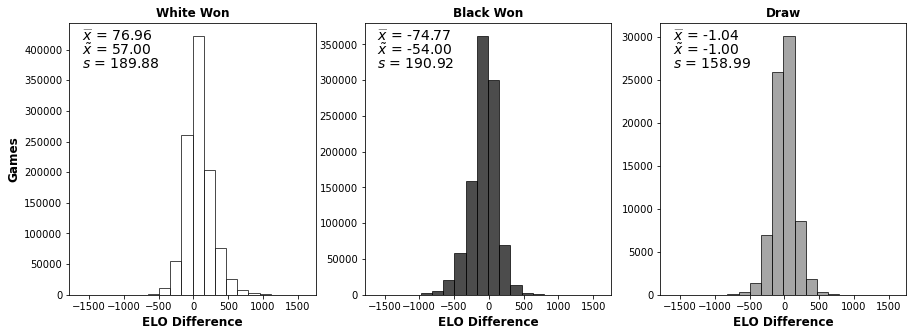

In [6]:
data['ELO Difference'] = (data['White ELO'] - data['Black ELO']).astype('int16')
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
r = (np.min(data['ELO Difference']), np.max(data['ELO Difference']))

axs[0].hist(data.loc[data['Result'] == '1-0']['ELO Difference'], bins=20, range=r, color='white', edgecolor='black', alpha=0.7)
axs[1].hist(data.loc[data['Result'] == '0-1']['ELO Difference'], bins=20, range=r, color='black', edgecolor='black', alpha=0.7)
axs[2].hist(data.loc[data['Result'] == '1/2-1/2']['ELO Difference'], bins=20, range=r, color='gray', edgecolor='black', alpha=0.7)

def add_info(ax, pNum, result, title):
     ax[pNum].set_title(title, size='large', fontweight='bold')
     ax[pNum].set_xlabel('ELO Difference', size='large', fontweight='bold')
     ax[pNum].text(0.05, 0.95, f"$\widebar{{x}}$ = {np.mean(data.loc[data['Result'] == result]['ELO Difference']):.2f}",\
          transform=ax[pNum].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=14)
     ax[pNum].text(0.05, 0.9, fr"$\tilde{{x}}$ = {np.median(data.loc[data['Result'] == result]['ELO Difference']):.2f}",\
          transform=ax[pNum].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=14)
     ax[pNum].text(0.05, 0.85, f"$s$ = {np.std(data.loc[data['Result'] == result]['ELO Difference']):.2f}",\
          transform=ax[pNum].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=14)

add_info(axs, 0, '1-0', 'White Won')
add_info(axs, 1, '0-1', 'Black Won')
add_info(axs, 2, '1/2-1/2', 'Draw')
axs[0].set_ylabel('Games', size='large', fontweight='bold');

Now let's combine the ELO Difference with Game Type to see if there might be an interaction between these two variables.

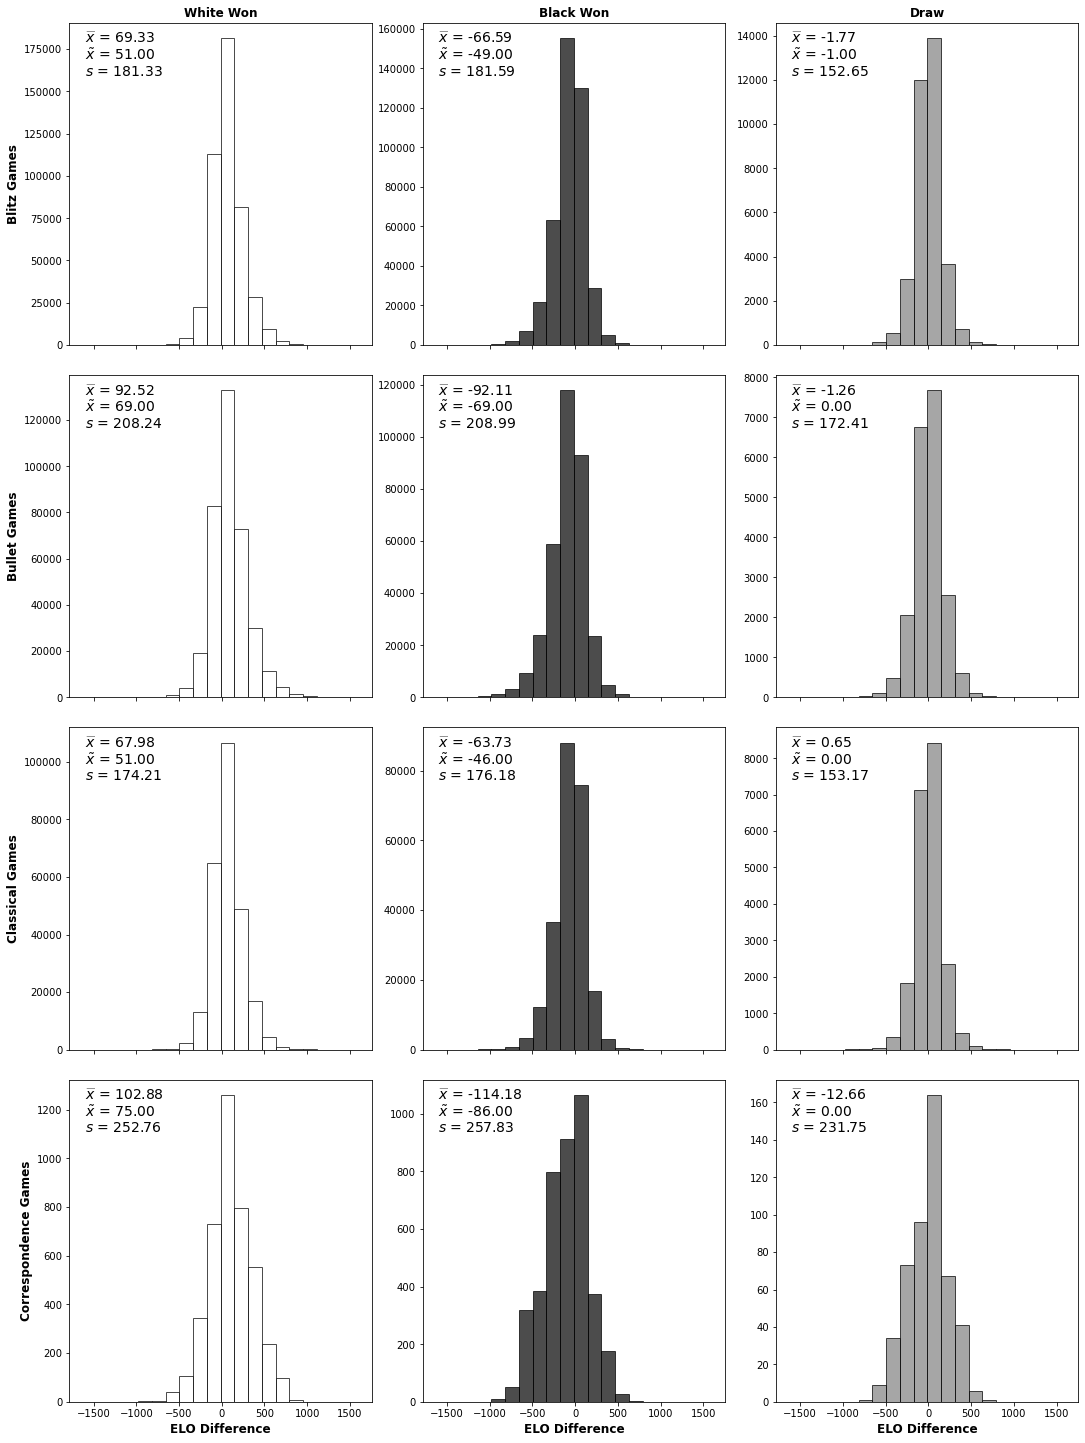

In [7]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20), sharex=True)
fig.tight_layout(pad=2)
gameTypes = ['Blitz', 'Bullet', 'Classical', 'Correspondence']
results = ['1-0', '0-1', '1/2-1/2']
colors = ['white', 'black', 'gray']
r = (np.min(data['ELO Difference']), np.max(data['ELO Difference']))

for i in range(4):
    for j in range(3):
        axs[i,j].hist(data.loc[(data['Game Type'] == gameTypes[i]) & (data['Result'] == results[j])]['ELO Difference'],\
             bins=20, range=r, color=colors[j], edgecolor='black', alpha=0.7)
        axs[i,j].text(0.05, 0.95, f"$\widebar{{x}}$ = {np.mean(data.loc[(data['Game Type'] == gameTypes[i]) & (data['Result'] == results[j])]['ELO Difference']):.2f}",\
             transform=axs[i,j].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=14)
        axs[i,j].text(0.05, 0.9, rf"$\tilde{{x}}$ = {np.median(data.loc[(data['Game Type'] == gameTypes[i]) & (data['Result'] == results[j])]['ELO Difference']):.2f}",\
             transform=axs[i,j].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=14)
        axs[i,j].text(0.05, 0.85, f"$s$ = {np.std(data.loc[(data['Game Type'] == gameTypes[i]) & (data['Result'] == results[j])]['ELO Difference']):.2f}",\
             transform=axs[i,j].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=14)

axs[0,0].set_title('White Won', fontweight='bold', size='large')
axs[0,1].set_title('Black Won', fontweight='bold', size='large')
axs[0,2].set_title('Draw', fontweight='bold', size='large')
axs[0,0].set_ylabel('Blitz Games', fontweight='bold', size='large')
axs[1,0].set_ylabel('Bullet Games', fontweight='bold', size='large')
axs[2,0].set_ylabel('Classical Games', fontweight='bold', size='large')
axs[3,0].set_ylabel('Correspondence Games', fontweight='bold', size='large')
axs[3,0].set_xlabel('ELO Difference', fontweight='bold', size='large')
axs[3,1].set_xlabel('ELO Difference', fontweight='bold', size='large')
axs[3,2].set_xlabel('ELO Difference', fontweight='bold', size='large');

There doesn't appear to be any interaction between `Game Type` and `ELO Difference`, so we can probably rule this out as an important distinction to make. Let's take a look at number of moves in each game and see if we can extract a pattern there.

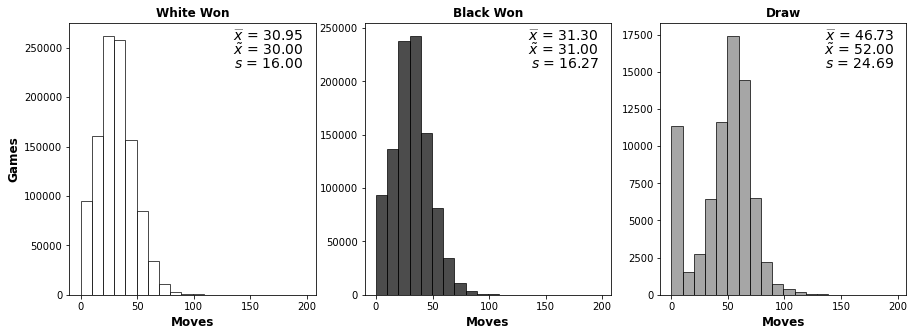

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
r = (np.min(data['Moves']), np.max(data['Moves']))

axs[0].hist(data.loc[data['Result'] == '1-0']['Moves'], bins=20, range=r, color='white', edgecolor='black', alpha=0.7)
axs[1].hist(data.loc[data['Result'] == '0-1']['Moves'], bins=20, range=r, color='black', edgecolor='black', alpha=0.7)
axs[2].hist(data.loc[data['Result'] == '1/2-1/2']['Moves'], bins=20, range=r, color='gray', edgecolor='black', alpha=0.7)

def add_info(ax, pNum, result, title):
     ax[pNum].set_title(title, size='large', fontweight='bold')
     ax[pNum].set_xlabel('Moves', size='large', fontweight='bold')
     ax[pNum].text(0.95, 0.95, f"$\widebar{{x}}$ = {np.mean(data.loc[data['Result'] == result]['Moves']):.2f}",\
          transform=ax[pNum].transAxes, horizontalalignment='right', verticalalignment='center', fontsize=14)
     ax[pNum].text(0.95, 0.9, fr"$\tilde{{x}}$ = {np.median(data.loc[data['Result'] == result]['Moves']):.2f}",\
          transform=ax[pNum].transAxes, horizontalalignment='right', verticalalignment='center', fontsize=14)
     ax[pNum].text(0.95, 0.85, f"$s$ = {np.std(data.loc[data['Result'] == result]['Moves']):.2f}",\
          transform=ax[pNum].transAxes, horizontalalignment='right', verticalalignment='center', fontsize=14)

add_info(axs, 0, '1-0', 'White Won')
add_info(axs, 1, '0-1', 'Black Won')
add_info(axs, 2, '1/2-1/2', 'Draw')
axs[0].set_ylabel('Games', size='large', fontweight='bold');

Again, doesn't look like there's a noticeable correlation between `Moves` and the result of the game, but let's plot the data by `ELO Difference` and `Moves`, coloring each point by the result of the game.

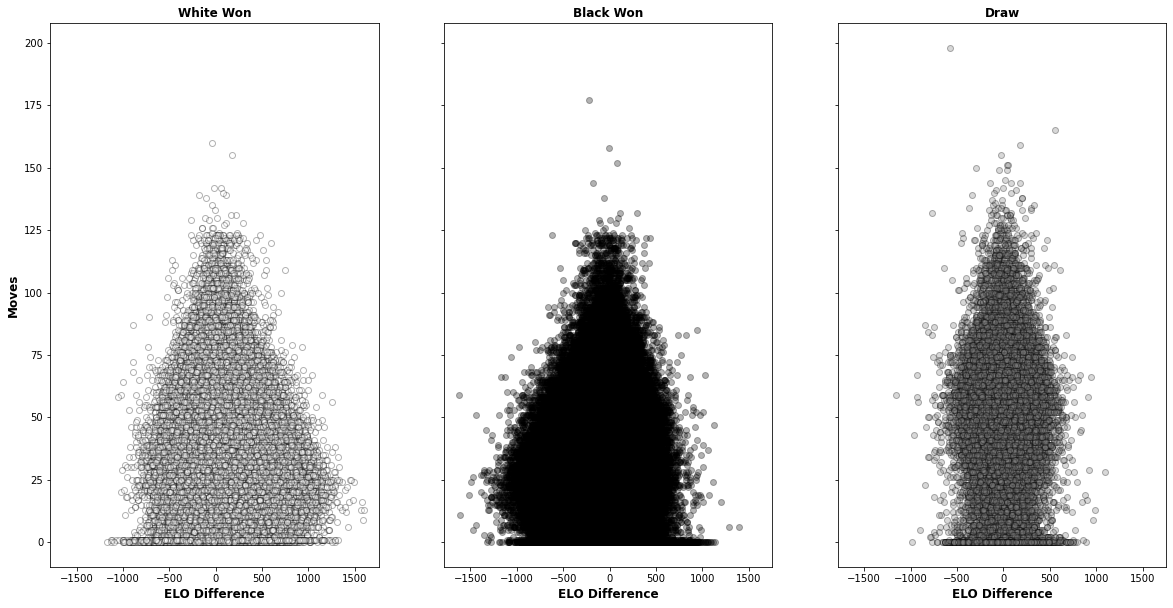

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(20,10), sharex=True, sharey=True)

axs[0].scatter(data.loc[data['Result']=='1-0']['ELO Difference'], data.loc[data['Result']=='1-0']['Moves'], c='white', edgecolors='black', alpha=0.3)
axs[1].scatter(data.loc[data['Result']=='0-1']['ELO Difference'], data.loc[data['Result']=='0-1']['Moves'], c='black', edgecolors='black', alpha=0.3)
axs[2].scatter(data.loc[data['Result']=='1/2-1/2']['ELO Difference'], data.loc[data['Result']=='1/2-1/2']['Moves'], c='gray', edgecolors='black', alpha=0.3)

axs[0].set_title('White Won', fontweight='bold', size='large')
axs[0].set_xlabel('ELO Difference', fontweight='bold', size='large')
axs[1].set_title('Black Won', fontweight='bold', size='large')
axs[1].set_xlabel('ELO Difference', fontweight='bold', size='large')
axs[2].set_title('Draw', fontweight='bold', size='large')
axs[2].set_xlabel('ELO Difference', fontweight='bold', size='large')
axs[0].set_ylabel('Moves', fontweight='bold', size='large');

These graphs don't really tell us anything about who will win, but they do give us some interesting information so I've kept them anyways. We can see that as the number of moves in a game increases, the spread in players' ELOs tightens, meaning more equally matched players will play longer games on average. The more drastically different two players' ELOs are, the shorter the game is. It might be interesting to do some analysis on these trends, but that is outside the scope of this project.

What we've gathered from these graphs is that ELO, more specifically ELO difference, is the best predictor of which player will win.